# Mobile price classification with multilayer perceptron
## PyTorch
Erik Matovič and Jakub Horvat

[Dataset](https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification?select=train.csv)

### 0. Imports

In [175]:
import wandb
from pprint import pprint
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from utils import split_train_val
from typing import Tuple, List
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, accuracy_score

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
print(use_cuda, device)

True cuda:0


In [176]:
wandb.login()

# wandb.require("service")

True

### 2. Data transformation
 - no null values
 - load train and test datasets & from test dataset make validation and test dataset

In [177]:
# read datasets
df_train = pd.read_csv('../data/train.csv', sep=',')
df_test = df_train[-200:]
df_train = df_train[:-200]
df_train

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,527,0,0.7,1,4,0,53,0.9,128,1,...,67,1924,1302,13,7,13,0,0,0,0
1796,793,1,2.8,1,1,1,64,0.4,179,4,...,818,1006,2296,12,0,5,1,1,0,1
1797,873,1,0.5,1,6,0,8,0.6,152,7,...,1257,1411,575,15,8,7,1,0,1,0
1798,722,0,1.1,0,12,0,12,1.0,93,6,...,138,1371,2359,13,6,3,0,0,0,1


In [178]:
# df_test = pd.read_csv('../data/test.csv', sep=',', index_col=0)
df_test

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
1800,1358,0,1.7,0,0,0,60,0.6,147,3,...,889,1635,440,14,10,13,1,0,0,0
1801,1035,1,1.9,1,8,0,11,1.0,173,6,...,831,1709,2002,17,8,5,1,1,0,1
1802,1289,0,0.8,1,3,1,16,0.9,161,6,...,713,1854,3167,14,8,20,1,1,0,3
1803,1445,0,2.2,1,2,0,37,0.4,82,2,...,527,1393,3480,17,16,17,1,1,1,3
1804,1702,1,2.3,1,12,1,47,0.6,107,2,...,1284,1643,595,10,0,19,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,...,1222,1890,668,13,4,19,1,1,0,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2
1997,1911,0,0.9,1,1,1,36,0.7,108,8,...,868,1632,3057,9,1,5,1,1,0,3
1998,1512,0,0.9,0,4,1,46,0.1,145,5,...,336,670,869,18,10,19,1,1,1,0


In [179]:
X_train = df_train.values[:, :-1]       # store the inputs
X_train = X_train.astype('float32')     # input data as floats
X_train

array([[8.420e+02, 0.000e+00, 2.200e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [1.021e+03, 1.000e+00, 5.000e-01, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       [5.630e+02, 1.000e+00, 5.000e-01, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       ...,
       [8.730e+02, 1.000e+00, 5.000e-01, ..., 1.000e+00, 0.000e+00,
        1.000e+00],
       [7.220e+02, 0.000e+00, 1.100e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.250e+03, 1.000e+00, 1.500e+00, ..., 1.000e+00, 1.000e+00,
        1.000e+00]], dtype=float32)

In [180]:
X_test = df_test.values[:, :-1]       # store the inputs
X_test = X_test.astype('float32')     # input data as floats
X_test

array([[1.358e+03, 0.000e+00, 1.700e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [1.035e+03, 1.000e+00, 1.900e+00, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       [1.289e+03, 0.000e+00, 8.000e-01, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       ...,
       [1.911e+03, 0.000e+00, 9.000e-01, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       [1.512e+03, 0.000e+00, 9.000e-01, ..., 1.000e+00, 1.000e+00,
        1.000e+00],
       [5.100e+02, 1.000e+00, 2.000e+00, ..., 1.000e+00, 1.000e+00,
        1.000e+00]], dtype=float32)

In [181]:
y_train = df_train.values[:, -1]  # store the outputs
y_train = y_train.astype('int')     # input data as floats
y_train

array([1, 2, 2, ..., 0, 1, 2])

In [182]:
y_test = df_test.values[:, -1]  # store the outputs
y_test = y_test.astype('int')     # input data as floats
y_test

array([0, 1, 3, 3, 1, 2, 1, 0, 0, 1, 0, 1, 0, 0, 1, 3, 3, 1, 0, 2, 0, 3,
       1, 2, 2, 1, 2, 3, 3, 0, 0, 1, 2, 2, 2, 1, 2, 1, 0, 2, 3, 0, 0, 3,
       0, 3, 0, 0, 3, 3, 0, 3, 0, 0, 0, 0, 3, 3, 2, 0, 0, 0, 0, 3, 0, 2,
       3, 2, 3, 3, 2, 3, 1, 0, 2, 0, 0, 1, 1, 1, 2, 2, 0, 0, 3, 0, 1, 2,
       0, 3, 1, 0, 0, 3, 0, 1, 0, 3, 3, 0, 1, 2, 2, 2, 3, 0, 1, 3, 3, 1,
       3, 0, 1, 0, 0, 2, 1, 0, 2, 0, 3, 1, 0, 2, 1, 2, 1, 3, 0, 2, 3, 1,
       1, 1, 2, 1, 3, 2, 2, 2, 2, 3, 1, 0, 0, 0, 0, 2, 1, 2, 1, 0, 1, 3,
       0, 3, 0, 3, 3, 1, 2, 0, 2, 1, 1, 0, 2, 1, 0, 2, 2, 1, 0, 3, 1, 3,
       0, 2, 1, 1, 1, 1, 2, 2, 1, 3, 1, 0, 1, 1, 0, 3, 0, 3, 3, 0, 2, 3,
       0, 3])

In [183]:
# make dataset from X and y
train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train, dtype=torch.long))
train_ds

In [184]:
# make dataset from X and y
test_ds = TensorDataset(torch.tensor(X_test), torch.tensor(y_test, dtype=torch.long))
test_ds

In [185]:
default_config = {
    'hidden_size': 256,
    'learning_rate': 0.01,
    'epochs': 500,
    'Adam_beta1': 0.99,
    'Adam_beta2': 0.999,
    'batch_size': 256
}

In [186]:
#batch_size = default_config['batch_size'] #128
tf_train, tf_val = split_train_val(train_ds)

print(tf_train.dataset)
print(tf_val.dataset)

In [187]:
#train_dl = DataLoader(tf_train, batch_size=batch_size, shuffle=True, num_workers=0)
#val_dl = DataLoader(tf_val, batch_size=batch_size, shuffle=False, num_workers=0)
#test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0) #.astype('float32')

#test_dl = DataLoader(torch.tensor(df_test.values), batch_size=batch_size, shuffle=False) #.astype('float32')

#print(len(train_dl.dataset))
#print(len(val_dl.dataset))
#print(len(test_dl.dataset))

#print(train_dl.dataset)
#print(val_dl.dataset)
#print(test_dl.dataset)

In [188]:
train_dl.dataset

## Model

In [189]:
class MLP(nn.Module):
    """ 
    Model class.
    :param Module from torch.nn
    """
    def __init__(self, n_inputs: int, n_classes: int, lr: float, hidden_size: float) -> None:
        """
        Model elements init.
        """
        super(MLP, self).__init__()
        self.n_inputs = n_inputs
        self.n_classes = n_classes
        self.lr = lr
        self.hidden_size = hidden_size
    
        # input to first hidden layer
        # pridať hlbku aj šírku siete
        # skúsiť normalizovať dáta
        self.dense1 = nn.Linear(n_inputs, self.hidden_size)
        # second hidden layer
        self.dense2 = nn.Linear(self.hidden_size, self.hidden_size)
        # third hidden layer and output
        self.dense3 = nn.Linear(self.hidden_size, self.hidden_size)
        self.dense4 = nn.Linear(self.hidden_size, self.hidden_size)
        self.dense5 = nn.Linear(self.hidden_size, self.hidden_size)
        self.dense6 = nn.Linear(self.hidden_size, self.n_classes)
        
        # activation f
        self.relu = nn.ReLU()
        # prv začat bez dropout, ptm pridat, pozrieť sa na parametre 
        # dropout pomaha proti preuceniu
        self.droput = nn.Dropout(p=0.2)
 
    def forward(self, X:torch.Tensor) -> torch.Tensor:
        """
        Feed forward
        """
        # print(type(X))
        #print(self.n_inputs)
        # input to first hidden layer
        output = self.dense1(X)
        output = self.relu(output)
        #output = self.droput(output)
        
        # second hidden layer
        output = self.dense2(output)
        output = self.relu(output)
        #output = self.droput(output)

        # third hidden layer
        output = self.dense3(output)
        output = self.relu(output)
        #output = self.droput(output)
        
        # second hidden layer
        output = self.dense4(output)
        output = self.relu(output)
        #output = self.droput(output)
        
        # second hidden layer
        output = self.dense5(output)
        output = self.relu(output)
        #output = self.droput(output)

        # final layer and output
        output = self.dense6(output)
        # print(type(output))

        # print(type(output))
        return output

In [190]:
# wandb.init(config=default_config)

#config = wandb.config
#print(config)

In [191]:
#learning_rate = default_config['learning_rate'] #config.learning_rate    #  # 0.001 
#input_size = 20                         # number of features
#hidden_size = default_config['hidden_size']#config.hidden_size        #  #64         # number of features in hidden state
#num_classes = 4                 # number of output classes 

#beta1 = default_config['Adam_beta1']#config.Adam_beta1       
#beta2 = default_config['Adam_beta2']#config.Adam_beta2       

#n_epochs = default_config['epochs']#config.epochs        
#batch_size = default_config['batch_size']#config.batch_size  

#mlp = MLP( 
#    n_inputs=input_size, 
#    n_classes=num_classes,
#    lr=learning_rate,
#    hidden_size=hidden_size)
#mlp.to(device)

#loss_fn = nn.CrossEntropyLoss()
#optimizer = optim.Adam(mlp.parameters(), lr=learning_rate) # SGD(mlp.parameters(), lr=learning_rate, momentum=momentum)

define the optimization and loss function

In [192]:
sweep_config = {
    'name': 'NSIETE_zad1',
    'method': 'bayes',
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'early_terminate':{
        'type': 'hyperband',
        'min_iter': 5
    },
    'parameters': {
        'batch_size': {
            'values': [32, 64, 128, 256]
        },
        'epochs': {
            'values': [30, 50, 80, 100, 500]
            #'min': 30,
            #'max': 100
        },
        'learning_rate': {
            'min': 0.0001,
            'max': 0.1
        },
        'Adam_beta1': {
            'min': 0.99,
            'max': 0.999
        },
        'Adam_beta2': {
            'min': 0.999,
            'max': 0.9999
        },
        'hidden_size': {
            'values': [32, 64, 128, 256, 512]
        }
    }
}

pprint(sweep_config)

sweep_id = wandb.sweep(sweep_config)#, project='NSIETE_zad1')

{'early_terminate': {'min_iter': 5, 'type': 'hyperband'},
 'method': 'bayes',
 'metric': {'goal': 'minimize', 'name': 'val_loss'},
 'name': 'NSIETE_zad1',
 'parameters': {'Adam_beta1': {'max': 0.999, 'min': 0.99},
                'Adam_beta2': {'max': 0.9999, 'min': 0.999},
                'batch_size': {'values': [32, 64, 128, 256]},
                'epochs': {'values': [30, 50, 80, 100, 500]},
                'hidden_size': {'values': [32, 64, 128, 256, 512]},
                'learning_rate': {'max': 0.1, 'min': 0.0001}}}
Create sweep with ID: 1kmqujzs
Sweep URL: https://wandb.ai/xmatovice/uncategorized/sweeps/1kmqujzs


In [193]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc


def train_mlp(n_epochs, mlp, optimizer, loss_fn, 
              train_dl, val_dl, device, batch_size):
    # init train lists for statistics
    loss_train, accuracy_train = list(), list()

    # init validation lists for statistics
    loss_validation, accuracy_validation = list(), list()

    # enumerate epochs
    for epoch in range(n_epochs):
        # init epoch train counters
        epoch_train_accuracy, epoch_train_total, epoch_train_true, epoch_train_loss = 0, 0, 0, 0

        # init epoch validation counters
        epoch_validation_accuracy, epoch_validation_total, \
            epoch_validation_true, epoch_validation_loss = 0, 0, 0, 0

        # enumerate mini batches
        for idx, (X_batch, y_batch) in enumerate(train_dl):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # print('y_batch', y_batch.shape)
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            # Make prediction logits with model
            y_logits = mlp(X_batch)
            # Perform softmax calculation on logits across dimension 1 to get prediction probabilities
            y_pred_probs = torch.softmax(y_logits, dim=1) 
            # go from logits -> prediction probabilities -> prediction labels
            y_pred = torch.argmax(y_pred_probs, dim=1) 
            
            loss = loss_fn(y_logits, y_batch)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()

            # update train counters
            epoch_train_loss += loss.item()
            # epoch_train_true += (y_batch == y_hat).sum().item()
            #epoch_train_true = accuracy_score(y_batch.cpu().detach().numpy(), y_hat.cpu().detach().numpy())
            epoch_train_true = accuracy_fn(y_batch, y_pred)
            epoch_train_total += len(y_batch)
        
        # update train accuracy & loss statistics
        epoch_train_accuracy = epoch_train_true/epoch_train_total
        epoch_train_loss /= (len(train_dl.dataset)/batch_size)

        # disable gradient calculation
        with torch.no_grad():
            # enumerate mini batches
            for idx, (X_batch, y_batch) in enumerate(val_dl):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                # compute the models output
                test_logits = mlp(X_batch)
                test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
                # y_hat = torch.argmax(y_hat, axis=-1)
                # calculate loss
                loss = loss_fn(test_logits, y_batch)

                # update validation counters
                epoch_validation_loss += loss.item()
                # epoch_validation_true += (y_batch == y_hat).sum().item()
                # epoch_validation_true = accuracy_score(y_batch.cpu(), y_hat.cpu())
                epoch_validation_true = accuracy_fn(y_batch, test_pred)
                epoch_validation_total += len(y_batch)
        
        # update validation accuracy & loss statistics
        epoch_validation_accuracy = epoch_validation_true/epoch_validation_total
        epoch_validation_loss /= (len(val_dl.dataset)/batch_size)

        # update global epochs statistics
        loss_train.append(epoch_train_loss)
        accuracy_train.append(epoch_train_accuracy)
        loss_validation.append(epoch_validation_loss)
        accuracy_validation.append(epoch_validation_accuracy)

        # log metrics to WandB
        wandb.log({"train loss": epoch_train_loss, 
                  "val_loss": epoch_validation_loss,
                  "train accuracy": epoch_train_accuracy,
                  "validation accuracy": epoch_validation_accuracy})

        # print
        if epoch == (n_epochs - 1): # 99:
            print(
                f'Epoch {epoch}/{n_epochs}: \
                train loss {loss_train[-1]}, \
                validation loss {loss_validation[-1]}, \
                train accuracy {accuracy_train[-1]}, \
                validation accuracy {accuracy_validation[-1]}'
            )

In [194]:
def evaluation(mlp, test_dl):
    #y_test_all, y_pred_all = evaluate(mlp, test_loader)

    y_pred_all, y_test_all = list(), list()

    total = 0
    correct = 0

    with torch.no_grad():
        for X_batch, y_batch in test_dl:
            # outputs = mlp(X_batch)
            # evaluate on test set
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_hat = mlp(X_batch)
            test_pred = torch.softmax(y_hat, dim=1).argmax(dim=1)
            # acc = accuracy_score(y_batch.cpu(), test_pred.cpu())
            epoch_validation_true = accuracy_fn(y_batch, test_pred)
            
            # print('Accuracy: %.3f' % epoch_validation_true)
            y_pred_all.extend(test_pred.cpu().numpy())
            y_test_all.extend(y_batch.cpu().numpy())
            #total += len(y_batch)
            #correct += (y_hat == y_batch).sum().item()
            wandb.log({'epoch test accuracy': epoch_validation_true})

    # return y_test_all, y_pred_all

    report = classification_report(y_test_all, y_pred_all, target_names=['0', '1', '2', '3'], digits=4)
    #print(report['precision'])
    #wandb.log({"precision": report['precision'], 
    #            "recall": report['recall'],
    #            "f1-score": report['f1-score'],
    #            "support": report['support']})
    print(report)

In [195]:
def wandb_sweep(): #-> Tuple[List, List, List, List]:
    """ 
    Train the model
    n_epochs, mlp, optimizer, loss_fn, 
              train_dl, val_dl, device, default_config
    """    
    # start a new wandb run to track this script
    wandb.init(
        # set the wandb project where this run will be logged
        project="NSIETE_zad1",
       # track hyperparameters and run metadata
        config=default_config
    )

    config = wandb.config

    learning_rate = config.learning_rate    #  # 0.001 
    input_size = 20                         # number of features
    hidden_size = config.hidden_size        #  #64         # number of features in hidden state
    num_classes = 4                 # number of output classes 

    beta1 = config.Adam_beta1       
    beta2 = config.Adam_beta2       

    n_epochs = config.epochs        
    batch_size = config.batch_size  

    train_dl = DataLoader(tf_train, batch_size=batch_size, shuffle=True, num_workers=0)
    val_dl = DataLoader(tf_val, batch_size=batch_size, shuffle=False, num_workers=0)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0) #.astype('float32')

    mlp = MLP( 
        n_inputs=input_size, 
        n_classes=num_classes,
        lr=learning_rate,
        hidden_size=hidden_size)
    mlp.to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(mlp.parameters(), lr=learning_rate, betas=(beta1, beta2)) # SGD(mlp.parameters(), lr=learning_rate, momentum=momentum)
    train_mlp(n_epochs, mlp, optimizer, loss_fn, 
              train_dl, val_dl, device, batch_size)
    
    evaluation(mlp, test_dl)
    # return loss_train, accuracy_train, loss_validation, accuracy_validation

In [196]:
#n_epochs = default_config['epochs']

# loss_train, accuracy_train, loss_validation, accuracy_validation = 
#train_mlp(
#    n_epochs=n_epochs,
#    mlp=mlp,
#    optimizer=optimizer,
#    loss_fn=loss_fn,
#    train_dl=train_dl,
#    val_dl=val_dl,
#    device=device
#)

In [197]:
#wandb_sweep()

In [198]:
wandb.agent(sweep_id, function=wandb_sweep, count=5)

wandb: Agent Starting Run: sg0ptrhy with config:
wandb: 	Adam_beta1: 0.993291451122785
wandb: 	Adam_beta2: 0.9993560517051489
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0733765419667522
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 29/30:                 train loss 1.4312420786162954,                 validation loss 1.9587237887912325,                 train accuracy 0.01469723691945914,                 validation accuracy 0.16025641025641024
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        63
           1     0.2450    1.0000    0.3936        49
           2     0.0000    0.0000    0.0000        42
           3     0.0000    0.0000    0.0000        46

    accuracy                         0.2450       200
   macro avg     0.0612    0.2500    0.0984       200
weighted avg     0.0600    0.2450    0.0964       200



epoch test accuracy,▁█
train accuracy,█▃▃▄▅▂▁▆▄▅▅▆▁▇▃▆▅▄▃▅▇▅▄▅▄▆▄▁▅▄
train loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▃▃█▄▂▂▁▂▂▂▁▁▂▂▂▂▂▁▃▂▂▂▂▂▂▄▂▁▁
validation accuracy,▁█▁█▁▁██▁▁▁██▁▁▁███▁▁█▁▁▁▁▁▁▁█
epoch test accuracy,30.55556
train accuracy,0.0147
train loss,1.43124
val_loss,1.95872
validation accuracy,0.16026


wandb: Agent Starting Run: yeipryg2 with config:
wandb: 	Adam_beta1: 0.9969176076272928
wandb: 	Adam_beta2: 0.9991477714146496
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.026269199445740195
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 99/100:                 train loss 1.423095354621793,                 validation loss 1.973032463921441,                 train accuracy 0.019841269841269844,                 validation accuracy 0.16025641025641024
              precision    recall  f1-score   support

           0     1.0000    0.0159    0.0312        63
           1     0.0000    0.0000    0.0000        49
           2     0.0000    0.0000    0.0000        42
           3     0.2312    1.0000    0.3755        46

    accuracy                         0.2350       200
   macro avg     0.3078    0.2540    0.1017       200
weighted avg     0.3682    0.2350    0.0962       200



epoch test accuracy,█▁
train accuracy,▅▂█▅▃▅▃▂█▃▁▂▂▄▁▄▃▂▃▁▄▄▃▂▂▄▄▃▂▄▄▃▄▁▂▄▃▂▅▆
train loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation accuracy,▇▁█▇▄▄▇▇▇▄▇▄▄▄▄▇▄▄▄▄▄▄▇▄▇▇▄▄▇▄▄▄▇▇▄▄▄▄▄▇
epoch test accuracy,20.83333
train accuracy,0.01984
train loss,1.4231
val_loss,1.97303
validation accuracy,0.16026


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i7qp2g7f with config:
wandb: 	Adam_beta1: 0.9985325196766536
wandb: 	Adam_beta2: 0.9993965835849452
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.016864252616057736
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 29/30:                 train loss 0.15205786912529556,                 validation loss 0.11259066131379869,                 train accuracy 0.05864197530864197,                 validation accuracy 0.5277777777777778
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        63
           1     0.9767    0.8571    0.9130        49
           2     0.8039    0.9762    0.8817        42
           3     1.0000    0.9348    0.9663        46

    accuracy                         0.9450       200
   macro avg     0.9452    0.9420    0.9403       200
weighted avg     0.9531    0.9450    0.9461       200



epoch test accuracy,▃▃▁▃▆▆█
train accuracy,▂▁▃▂▇▄▄▄▇▂▁▇▇██▆▆▅▇▇▅▇▇▇▇▆█▇▇▇
train loss,█▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▅▄▄▄▄▃▃▂▂▂▂▂▂▂▂▃▃▁▁▁▁▂▁▁▁▁
validation accuracy,▁▄▅▄▅▄▄▆▄▆▅▇▇▆▆▆▇▅█▇▇███▇▅▆▇█▇
epoch test accuracy,100.0
train accuracy,0.05864
train loss,0.15206
val_loss,0.11259
validation accuracy,0.52778


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bfwmsxwu with config:
wandb: 	Adam_beta1: 0.9931979949401896
wandb: 	Adam_beta2: 0.9998189598670654
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0808382028976673
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 99/100:                 train loss 1.425580601633331,                 validation loss 1.4863411373562283,                 train accuracy 0.015432098765432098,                 validation accuracy 0.11752136752136752
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        63
           1     0.0000    0.0000    0.0000        49
           2     0.2100    1.0000    0.3471        42
           3     0.0000    0.0000    0.0000        46

    accuracy                         0.2100       200
   macro avg     0.0525    0.2500    0.0868       200
weighted avg     0.0441    0.2100    0.0729       200



epoch test accuracy,▄▆█▁
train accuracy,▅▅▅▅▅▁▅▅▅▅▆▃▂▆▃▂▁▃▆▅▅▆▆▆▅▅▇▅▇▄▂▃▃▅▂▅▅▄█▅
train loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation accuracy,█████▁██▁▁█▁█▁▁█▁▁▁▁█▁█▁▁█▁▁█▁▁▁▁▁▁▁▁▁█▁
epoch test accuracy,12.5
train accuracy,0.01543
train loss,1.42558
val_loss,1.48634
validation accuracy,0.11752


wandb: Agent Starting Run: a24c6i2l with config:
wandb: 	Adam_beta1: 0.997250710972458
wandb: 	Adam_beta2: 0.999479590619658
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.013923315266630786
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 29/30:                 train loss 0.4261131004050926,                 validation loss 0.349529669019911,                 train accuracy 0.05246913580246913,                 validation accuracy 0.45940170940170943
              precision    recall  f1-score   support

           0     0.9091    0.9524    0.9302        63
           1     0.7368    0.8571    0.7925        49
           2     0.7250    0.6905    0.7073        42
           3     0.9730    0.7826    0.8675        46

    accuracy                         0.8350       200
   macro avg     0.8360    0.8207    0.8244       200
weighted avg     0.8429    0.8350    0.8352       200



epoch test accuracy,▃▁▁█
train accuracy,▁▄▅▅▅▄▅▅▇▇▇▇▄▅▆▅▅▆▅▅▆▆▇▆▇▇▇▇█▇
train loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▅▄▅▃▃▄▄▃▃▄▃▄▂▂▂▂▂▂▂▁▁▁▂▂▁▁
validation accuracy,▁▂▁▃▄▃▆▄▆▅▄▆▆▄▆▆▆▆▆▇▇▇▇███▆▇▇▇
epoch test accuracy,87.5
train accuracy,0.05247
train loss,0.42611
val_loss,0.34953
validation accuracy,0.4594


In [199]:
wandb.finish()

In [200]:
api = wandb.Api()
sweep = api.sweep("xmatovice/uncategorized/sweeps/" + sweep_id)

best_run = sweep.best_run()
print(best_run.id)
pprint(best_run.config)

wandb: Sorting runs by +summary_metrics.val_loss


i7qp2g7f
{'Adam_beta1': 0.9985325196766536,
 'Adam_beta2': 0.9993965835849452,
 'batch_size': 32,
 'epochs': 30,
 'hidden_size': 128,
 'learning_rate': 0.016864252616057736}


In [201]:
#y_test_all, y_pred_all = evaluate(mlp, test_loader)

y_pred_all, y_test_all = list(), list()

total = 0
correct = 0

with torch.no_grad():
    for X_batch, y_batch in test_dl:
        # outputs = mlp(X_batch)
        # evaluate on test set
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_hat = mlp(X_batch)
        test_pred = torch.softmax(y_hat, dim=1).argmax(dim=1)
        # acc = accuracy_score(y_batch.cpu(), test_pred.cpu())
        epoch_validation_true = accuracy_fn(y_batch, test_pred)
        
        print('Accuracy: %.3f' % epoch_validation_true)
        y_pred_all.extend(test_pred.cpu().numpy())
        y_test_all.extend(y_batch.cpu().numpy())
        #total += len(y_batch)
        #correct += (y_hat == y_batch).sum().item()

# return y_test_all, y_pred_all

report = classification_report(y_test_all, y_pred_all, target_names=['0', '1', '2', '3'], digits=4)
print(report)

NameError: name 'mlp' is not defined

In [ ]:
print(y_test_all)

[0, 1, 3, 3, 1, 2, 1, 0, 0, 1, 0, 1, 0, 0, 1, 3, 3, 1, 0, 2, 0, 3, 1, 2, 2, 1, 2, 3, 3, 0, 0, 1, 2, 2, 2, 1, 2, 1, 0, 2, 3, 0, 0, 3, 0, 3, 0, 0, 3, 3, 0, 3, 0, 0, 0, 0, 3, 3, 2, 0, 0, 0, 0, 3, 0, 2, 3, 2, 3, 3, 2, 3, 1, 0, 2, 0, 0, 1, 1, 1, 2, 2, 0, 0, 3, 0, 1, 2, 0, 3, 1, 0, 0, 3, 0, 1, 0, 3, 3, 0, 1, 2, 2, 2, 3, 0, 1, 3, 3, 1, 3, 0, 1, 0, 0, 2, 1, 0, 2, 0, 3, 1, 0, 2, 1, 2, 1, 3, 0, 2, 3, 1, 1, 1, 2, 1, 3, 2, 2, 2, 2, 3, 1, 0, 0, 0, 0, 2, 1, 2, 1, 0, 1, 3, 0, 3, 0, 3, 3, 1, 2, 0, 2, 1, 1, 0, 2, 1, 0, 2, 2, 1, 0, 3, 1, 3, 0, 2, 1, 1, 1, 1, 2, 2, 1, 3, 1, 0, 1, 1, 0, 3, 0, 3, 3, 0, 2, 3, 0, 3]


In [ ]:
print(y_pred_all)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


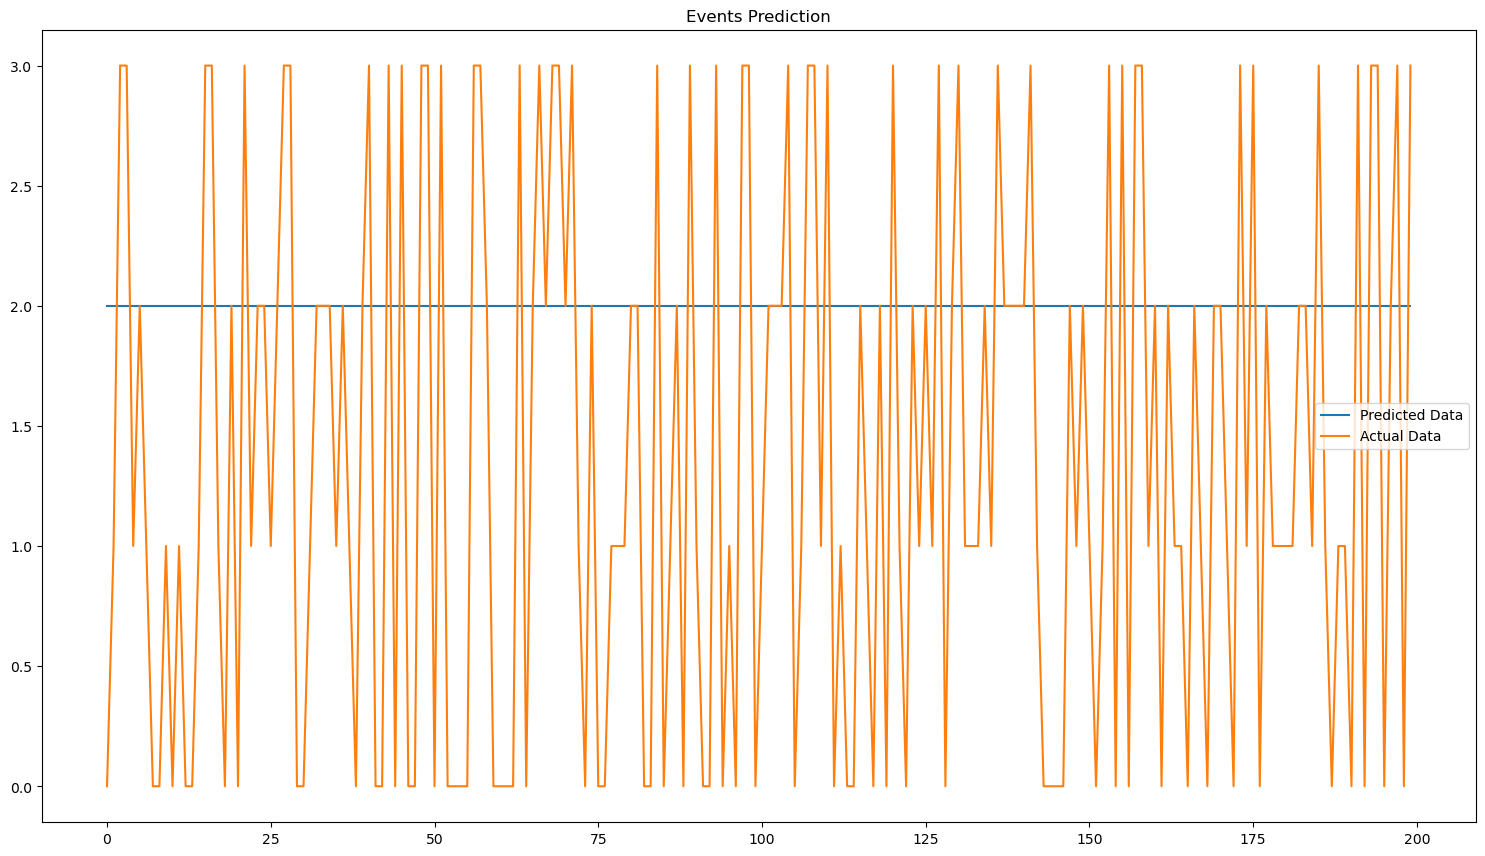

In [ ]:
from matplotlib import pyplot as plt

f = plt.figure(figsize=(10,6)) #plotting
f.set_size_inches(18.5, 10.5)
f.set_dpi(100)
#plt.axvline(x=0.95, c='r', linestyle='--') # size of the training set

plt.plot(y_pred_all, label='Predicted Data') # predicted plot
plt.plot(y_test_all, label='Actual Data') # actual plot
plt.title('Events Prediction')
#plt.xlim([0, 10])
#plt.ylim([0, 7])
# my_yticks = ['', ]
#plt.yticks(true, true_new)
#plt.yticks(preds_round, preds_new)
plt.legend()
#plt.savefig("../outputs/1_bitcoin_high_prediction_pytorch.png", transparent=False, dpi=300)
plt.show() 

In [ ]:

def plot_loss(train_loss, val_loss):
    '''
    Visualize training loss vs. validation loss.
    Parameters
    ----------
    train_loss: training loss
    val_loss: validation loss
    Returns: None
    -------
    '''
    f = plt.figure(figsize=(10,6)) #plotting
    f.set_size_inches(18.5, 10.5)
    f.set_dpi(100)

    loss_csv = pd.DataFrame({"epochs": range(len(train_loss)), "train_loss": train_loss,
                             "val_loss": val_loss})
    # loss_csv.to_csv("../outputs/loss.csv")
    # gca stands for 'get current axis'
    ax = plt.gca()
    loss_csv.plot(kind='line',x='epochs',y='train_loss',ax=ax )
    loss_csv.plot(kind='line',x='epochs',y='val_loss', color='red', ax=ax)
    plt.title(f'Train loss vs Validation loss on {len(train_loss)} epochs')
    plt.show()
    # plt.savefig("../outputs/train_vs_val_loss.png")

# Examine results
plot_loss(loss_train, loss_validation)

NameError: name 'loss_train' is not defined

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


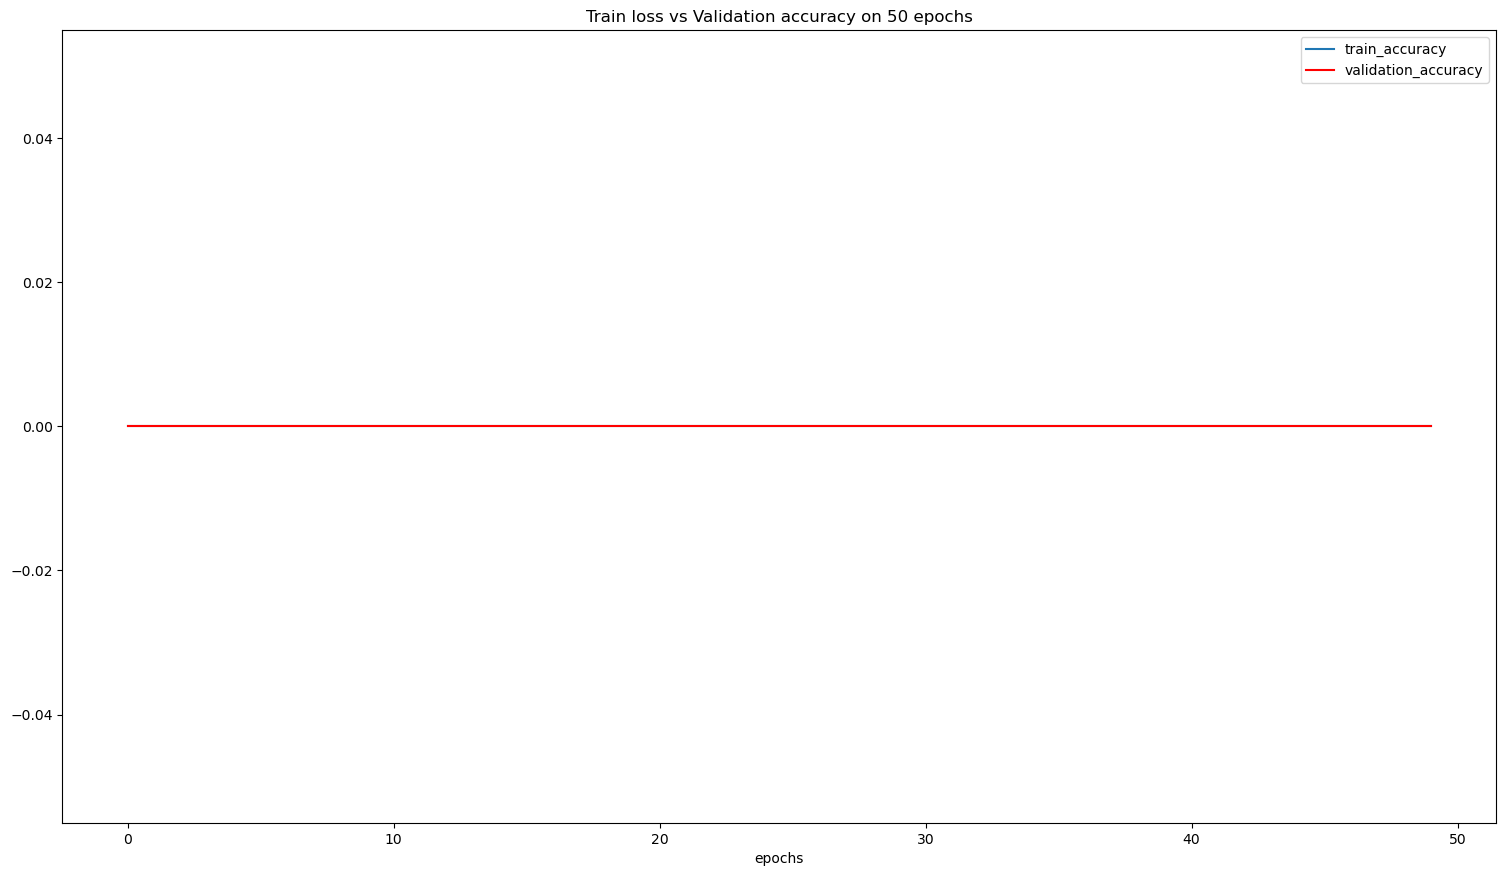

In [ ]:
def plot_accuracy(train_accuracy, validation_accuracy):
    """
    TODO: refactor
    """
    f = plt.figure(figsize=(10,6)) #plotting
    f.set_size_inches(18.5, 10.5)
    f.set_dpi(100)

    accuracy_csv = pd.DataFrame({
        "epochs": range(len(train_accuracy)), 
        "train_accuracy": train_accuracy,
        "validation_accuracy": validation_accuracy
    })
    # loss_csv.to_csv("../outputs/loss.csv")
    # gca stands for 'get current axis'
    ax = plt.gca()
    accuracy_csv.plot(kind='line',x='epochs',y='train_accuracy', ax=ax)
    accuracy_csv.plot(kind='line',x='epochs',y='validation_accuracy', color='red', ax=ax)
    plt.title(f'Train loss vs Validation accuracy on {len(train_accuracy)} epochs')
    plt.show()

print(accuracy_train, accuracy_validation)
plot_accuracy(accuracy_train, accuracy_validation)

In [ ]:
#df_X_ss = high_scaler.inverse_transform(X_test) # old transformers
#df_y_mm = high_scaler.inverse_transform(y_test) # old transformers

# split the sequence

# converting to tensors
#df_X_ss = Variable(torch.Tensor(df_X_ss))
#df_y_mm = Variable(torch.Tensor(df_y_mm))

# reshaping the dataset
#df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))
true, preds = [], []
# test_loader = DataLoader(TensorDataset(X_test_tensors, y_test_tensors), shuffle=False, batch_size=32)
for idx, X_batch in enumerate(test_dl):
    #print(y_batch)
    #break
    X_batch = X_batch.to(device)
    train_predict = mlp(X_batch) #X_test_tensors) # forward pass
    # torch.reshape(train_predict, (32, 1))
    data_predict = train_predict.cpu().data.numpy() # numpy conversion
    # dataY_plot = y_batch.data.numpy() # y_test_tensors.data.numpy()
    # print(data_predict[0].shape)
    # reverse transformation
    # data_predict = event_scaler.inverse_transform(data_predict[0]) 
    # dataY_plot = event_scaler.inverse_transform(dataY_plot)
    # true, preds = [], []
    #for i in range(len(dataY_plot)):
    #    true.append(dataY_plot[i][0])
    for i in range(len(data_predict)):
        # print(data_predict)
        preds.append(data_predict[i][0])

preds

[-25.18835,
 -34.959557,
 -3.4996955,
 -20.803446,
 -2.8113327,
 -19.01442,
 -22.290127,
 8.772235,
 -23.84472,
 11.533969,
 -16.205988,
 -29.305408,
 17.553339,
 38.109413,
 0.27140847,
 46.033142,
 -2.4158516,
 -0.5566572,
 -21.554802,
 -21.468914,
 31.330336,
 -20.321594,
 -1.9769732,
 0.27140847,
 -39.984436,
 30.120012,
 -16.525478,
 11.019178,
 -14.454321,
 4.938255,
 -10.202614,
 24.713001,
 -20.205585,
 22.074799,
 6.8733854,
 10.306226,
 -18.288311,
 -5.577177,
 -18.819494,
 -20.308739,
 13.561508,
 -4.542787,
 11.962477,
 49.74182,
 38.700043,
 -3.6929278,
 2.024644,
 -8.309422,
 17.424995,
 -9.788513,
 -0.023500353,
 6.5545225,
 -7.6261244,
 -3.1219594,
 -20.381927,
 11.8115225,
 -26.057304,
 1.6435716,
 0.06735486,
 -43.58432,
 -28.230303,
 -8.949297,
 0.27140847,
 -1.8809925,
 9.85161,
 -5.111064,
 -2.9560678,
 -10.734477,
 -3.4850068,
 -6.4516835,
 6.5196548,
 -8.763587,
 -7.8113112,
 -14.806311,
 -19.036217,
 12.025929,
 -8.835584,
 36.266922,
 -7.2433825,
 -20.7431,
 10

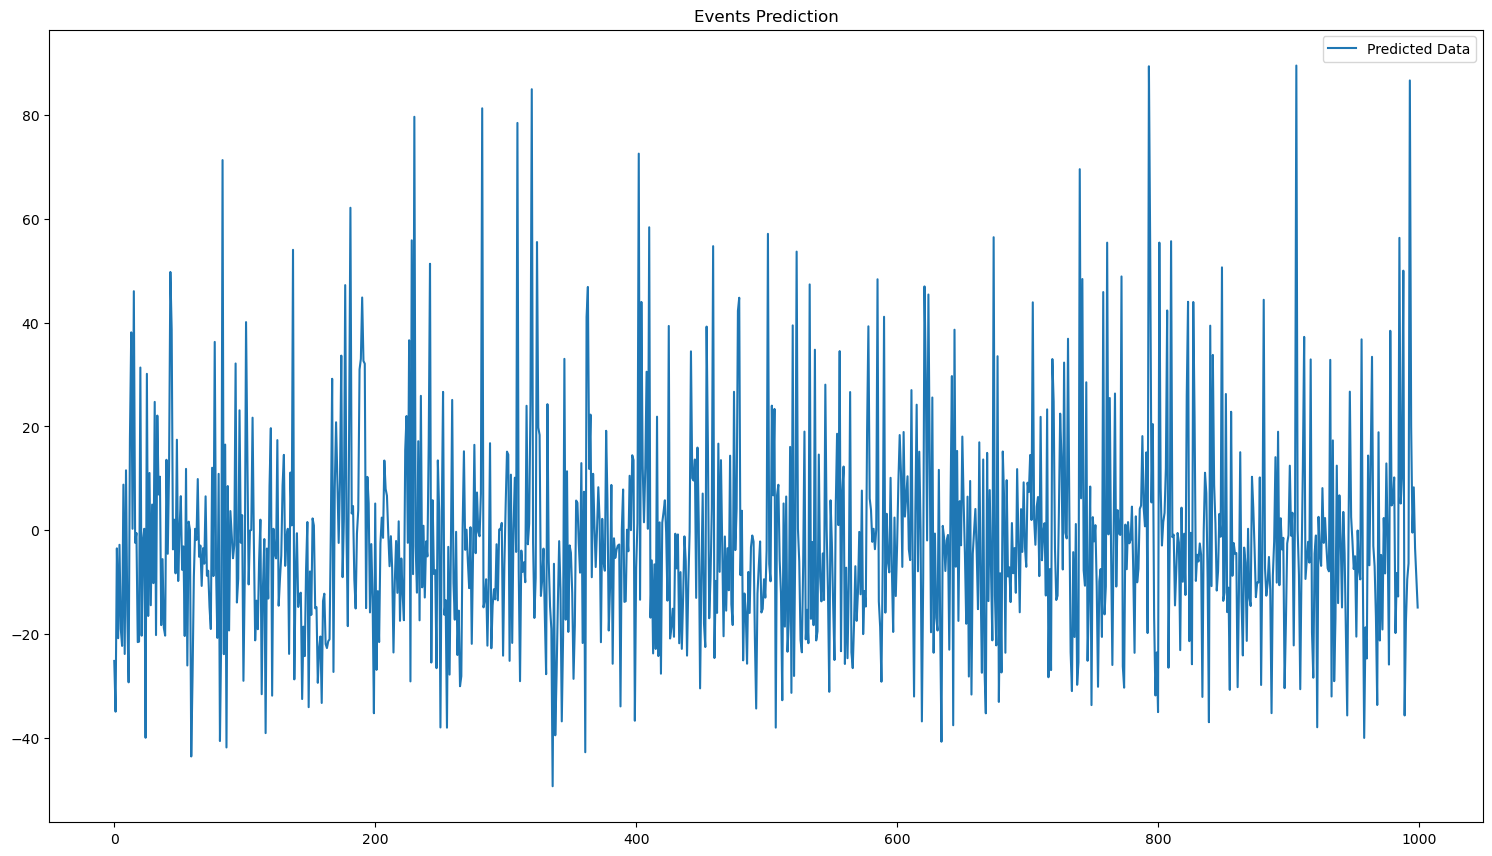

In [ ]:
f = plt.figure(figsize=(10,6)) #plotting
f.set_size_inches(18.5, 10.5)
f.set_dpi(100)
#plt.axvline(x=0.95, c='r', linestyle='--') # size of the training set

#plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Events Prediction')
#plt.xlim([500, 1000])
#plt.ylim([0, 7])
# my_yticks = ['', ]
#plt.yticks(true, true_new)
#plt.yticks(preds_round, preds_new)
plt.legend()
#plt.savefig("../outputs/1_bitcoin_high_prediction_pytorch.png", transparent=False, dpi=300)
plt.show() 

In [ ]:
#df_X_ss = high_scaler.inverse_transform(X_test) # old transformers
#df_y_mm = high_scaler.inverse_transform(y_test) # old transformers

# split the sequence

# converting to tensors
#df_X_ss = Variable(torch.Tensor(df_X_ss))
#df_y_mm = Variable(torch.Tensor(df_y_mm))

# reshaping the dataset
#df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))
true_val, preds_val = [], []
# test_loader = DataLoader(TensorDataset(X_test_tensors, y_test_tensors), shuffle=False, batch_size=32)
for idx, (X_batch, y_batch) in enumerate(val_dl):
    #print(y_batch)
    #break
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    train_predict = mlp(X_batch) #X_test_tensors) # forward pass
    # torch.reshape(train_predict, (32, 1))
    data_predict = train_predict.cpu().data.numpy() # numpy conversion
    dataY_plot = y_batch.cpu().data.numpy() # y_test_tensors.data.numpy()
    # print(data_predict[0].shape)
    # reverse transformation
    # data_predict = event_scaler.inverse_transform(data_predict[0]) 
    # dataY_plot = event_scaler.inverse_transform(dataY_plot)
    # true, preds = [], []
    for i in range(len(dataY_plot)):
        #print(dataY_plot[i])
        true_val.append(dataY_plot[i])
    for i in range(len(data_predict)):
        # print(data_predict)
        preds_val.append(data_predict[i][0])

preds

[-25.18835,
 -34.959557,
 -3.4996955,
 -20.803446,
 -2.8113327,
 -19.01442,
 -22.290127,
 8.772235,
 -23.84472,
 11.533969,
 -16.205988,
 -29.305408,
 17.553339,
 38.109413,
 0.27140847,
 46.033142,
 -2.4158516,
 -0.5566572,
 -21.554802,
 -21.468914,
 31.330336,
 -20.321594,
 -1.9769732,
 0.27140847,
 -39.984436,
 30.120012,
 -16.525478,
 11.019178,
 -14.454321,
 4.938255,
 -10.202614,
 24.713001,
 -20.205585,
 22.074799,
 6.8733854,
 10.306226,
 -18.288311,
 -5.577177,
 -18.819494,
 -20.308739,
 13.561508,
 -4.542787,
 11.962477,
 49.74182,
 38.700043,
 -3.6929278,
 2.024644,
 -8.309422,
 17.424995,
 -9.788513,
 -0.023500353,
 6.5545225,
 -7.6261244,
 -3.1219594,
 -20.381927,
 11.8115225,
 -26.057304,
 1.6435716,
 0.06735486,
 -43.58432,
 -28.230303,
 -8.949297,
 0.27140847,
 -1.8809925,
 9.85161,
 -5.111064,
 -2.9560678,
 -10.734477,
 -3.4850068,
 -6.4516835,
 6.5196548,
 -8.763587,
 -7.8113112,
 -14.806311,
 -19.036217,
 12.025929,
 -8.835584,
 36.266922,
 -7.2433825,
 -20.7431,
 10

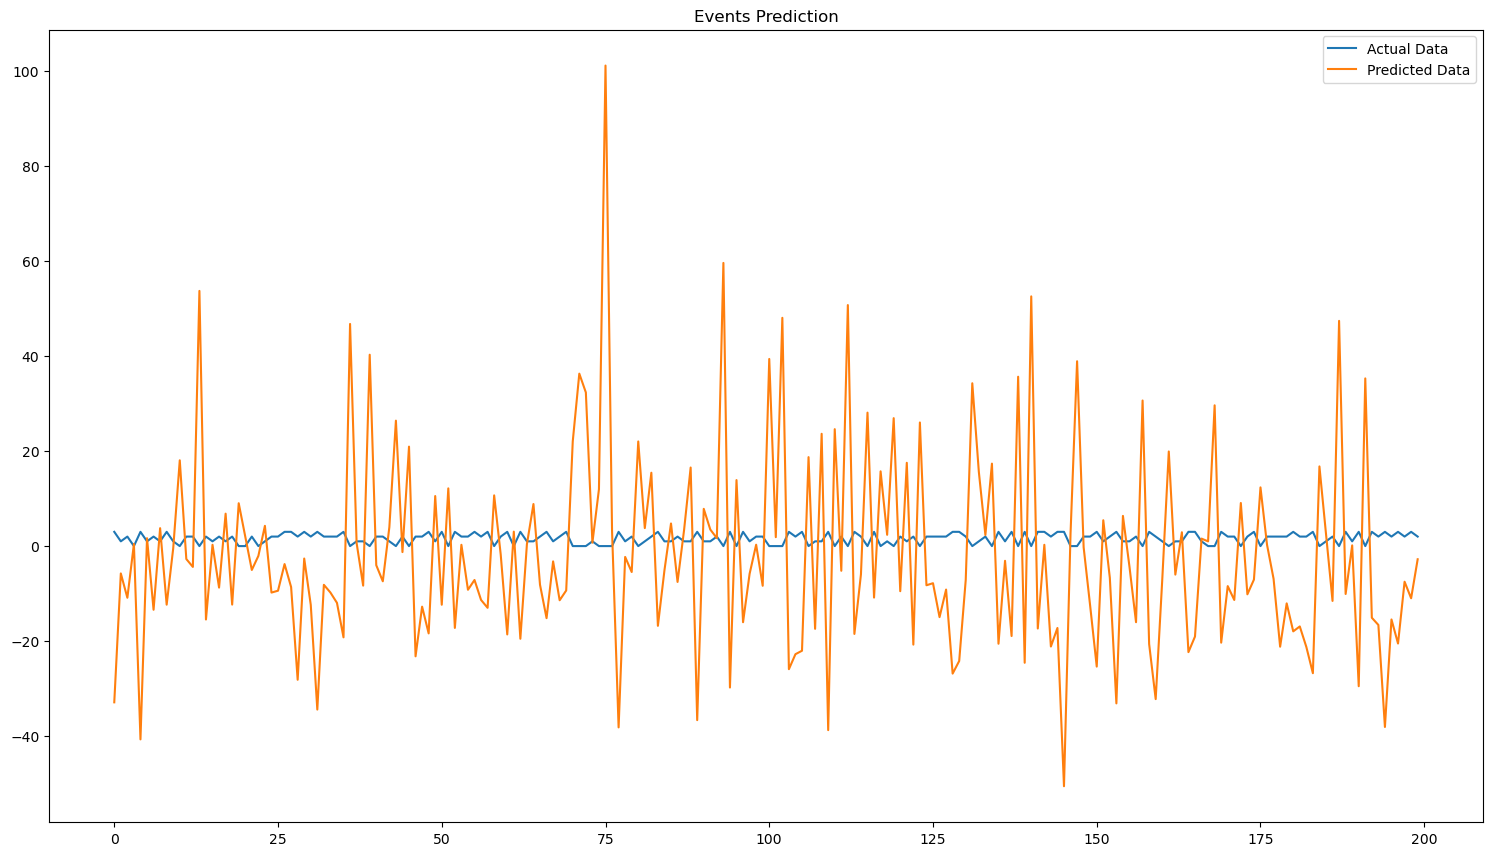

In [ ]:
f = plt.figure(figsize=(10,6)) #plotting
f.set_size_inches(18.5, 10.5)
f.set_dpi(100)
#plt.axvline(x=0.95, c='r', linestyle='--') # size of the training set

plt.plot(true_val, label='Actual Data') # actual plot
plt.plot(preds_val, label='Predicted Data') # predicted plot
plt.title('Events Prediction')
#plt.xlim([500, 1000])
#plt.ylim([0, 7])
# my_yticks = ['', ]
#plt.yticks(true, true_new)
#plt.yticks(preds_round, preds_new)
plt.legend()
#plt.savefig("../outputs/1_bitcoin_high_prediction_pytorch.png", transparent=False, dpi=300)
plt.show() 